In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

### Set Random seed

This is to ensure results are repoducibile and consistent across runs

In [2]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST("./data", train=False, transform=transform, download=True)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
    
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Training subset: {len(train_subset)}")
print(f"Validation images: {len(val_subset)}")
print(f"Test images: {len(test_dataset)}")

classes = train_dataset.classes

Training images: 60000
Training subset: 54000
Validation images: 6000
Test images: 10000


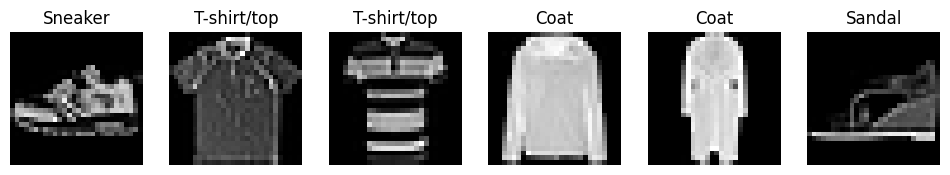

In [4]:
def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.show()

show_samples()

### **Simple CNN Architecture**

- **Convolution Layers:**  
  - Conv1: 1 → 32 filters  
  - Conv2: 32 → 64 filters  
  - Each followed by ReLU + **MaxPool**  
  - Spatial size: **28 → 14 → 7**

- **Fully Connected Layers:**  
  - Flatten: 64 × 7 × 7 = **3136**  
  - FC1: 3136 → 128  
  - FC2: 128 → 10 (logits)

**Flow:**  
Conv1 → ReLU → Pool → Conv2 → ReLU → Pool → Flatten → FC1 → FC2

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1 channel → 32 filters
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # 32 → 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # pooling reduces spatial size
        self.pool = nn.MaxPool2d(2, 2)

        # after two pools: 28×28 → 14×14 → 7×7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Conv → ReLU → Pool
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [7]:
patience = 3              # number of epochs to wait for improvement
best_val_loss = np.inf
epochs_no_improve = 0
max_epochs = 1000         # just a safety limit
best_model_state = None

for epoch in range(1, max_epochs + 1):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # -------- Validation Step --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:   # Make sure you have a val_loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -------- Early Stopping Logic --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("\nEarly stopping triggered!")
        print(f"Best Validation Loss: {best_val_loss:.4f}")
        break

# Load the best model state
model.load_state_dict(best_model_state)
print("Restored best model parameters.")

Epoch 1 | Train Loss: 0.4812 | Val Loss: 0.3451
Epoch 2 | Train Loss: 0.3065 | Val Loss: 0.2815
Epoch 3 | Train Loss: 0.2613 | Val Loss: 0.2827
  No improvement for 1 epoch(s).
Epoch 4 | Train Loss: 0.2294 | Val Loss: 0.2432
Epoch 5 | Train Loss: 0.2055 | Val Loss: 0.2273
Epoch 6 | Train Loss: 0.1836 | Val Loss: 0.2502
  No improvement for 1 epoch(s).
Epoch 7 | Train Loss: 0.1647 | Val Loss: 0.2156
Epoch 8 | Train Loss: 0.1441 | Val Loss: 0.2215
  No improvement for 1 epoch(s).
Epoch 9 | Train Loss: 0.1289 | Val Loss: 0.2064
Epoch 10 | Train Loss: 0.1109 | Val Loss: 0.2263
  No improvement for 1 epoch(s).
Epoch 11 | Train Loss: 0.0968 | Val Loss: 0.2365
  No improvement for 2 epoch(s).
Epoch 12 | Train Loss: 0.0844 | Val Loss: 0.2287
  No improvement for 3 epoch(s).

Early stopping triggered!
Best Validation Loss: 0.2064
Restored best model parameters.


In [8]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

mis_images = []
mis_preds = []
mis_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for img, pred, label in zip(images, predicted, labels):
            if pred != label:
                mis_images.append(img.cpu())
                mis_preds.append(pred.item())
                mis_labels.append(label.item())

accuracy = 100 * correct / total
f1_score_value = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"F1 Score (Weighted): {f1_score_value:.4f}")

Test Accuracy: 92.06%
F1 Score (Weighted): 0.9207


<Figure size 1600x1200 with 0 Axes>

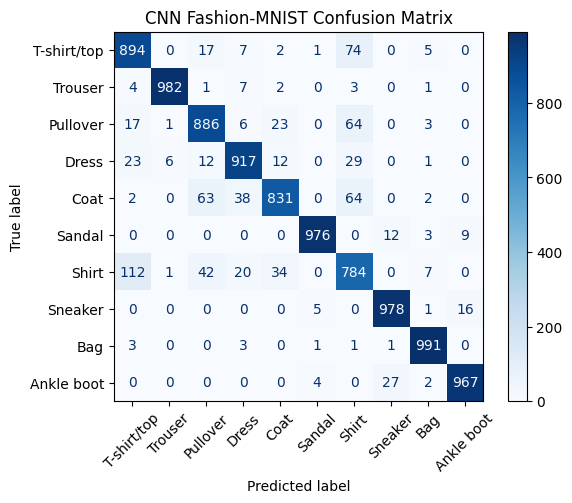

In [9]:

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(16, 12))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45)
plt.title("CNN Fashion-MNIST Confusion Matrix")
plt.show()


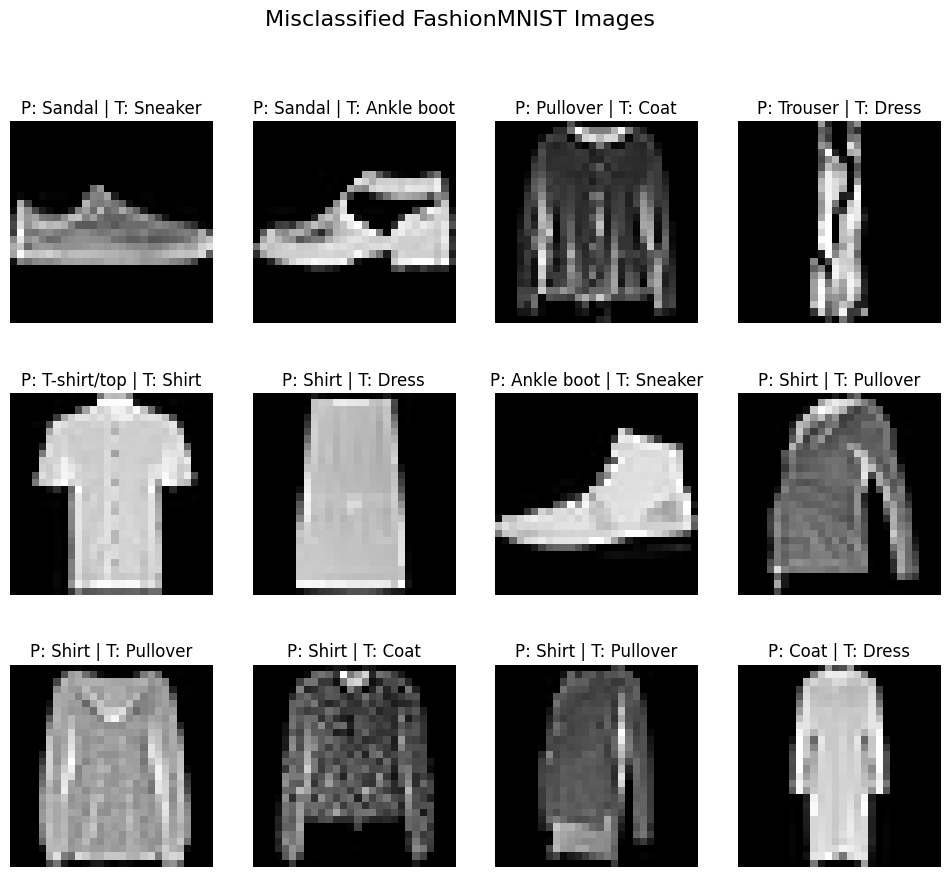

In [10]:
num_to_show = 12
plt.figure(figsize=(12, 10))
classes = test_dataset.classes

for i in range(num_to_show):
    plt.subplot(3, 4, i+1)
    plt.imshow(mis_images[i].squeeze(), cmap='gray')
    plt.title(f"P: {classes[mis_preds[i]]} | T: {classes[mis_labels[i]]}")
    plt.axis("off")

plt.suptitle("Misclassified FashionMNIST Images", fontsize=16)
plt.show()

## Analysis of Results and Trade-offs with MLP

The MLP (88.51%) lagged behind all convolutional models. By flattening the 28 × 28 image into
a vector, the MLP destroyed local spatial correlations. The CNNs (92%+) successfully
leveraged spatial invariance through pooling and kernels.